# Universal antagonism classification
For the library of HHAT-p8F-derived peptides and the TCR specific to HHAT-p8F, predict whether they will be agonists or antagonists, given their EC$_{50}$, which we fitted on our own dose response measurements (January 2024 experiment). 

## Predicting antagonism
Once we have an EC50 for all peptides, we convert them to $\tau$s and use the revised AKPR model to predict the antagonism or enhancement each peptide would cause. We set antigen abundances $L^\rho$ based on measurements of CAR antigen and MHC abundance on the target tumor cells, here assumed to be PC9 tumors. 

## Strategy to generate complete prediction confidence intervals

We will propagate the following sources of uncertainty to these model predictions in particular, since there is no experimental data to confirm the model $FC$ predictions, so we want to convey the high level of uncertainty associated with these predictions, beyond just uncertainty on the best model parameter fits. 

- TCR/CAR model parameters: from MCMC samples of revised AKPR model parameter fits
- Antigen densities: assume log-normal distributions around the "average APC" on which the ODE model is based. The standard deviation of this distribution is the standard error on the statistical mean estimator. 
- Peptide affinities: from a log-normal fit on the MCMC distribution of dose response curve parameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import json, h5py
import os

from utils.cpu_affinity import count_parallel_cpu
from utils.fitting import hill_with_back_diff

n_cpu = count_parallel_cpu()

In [2]:
from utils.preprocess import michaelis_menten, write_conc_uM, geo_mean_apply
from models.conversion import convert_ec50_tau_relative
from mcmc.plotting import change_log_ticks
from mcmc.costs_tcr_car_antagonism import antag_ratio_panel_tcr_car
from mcmc.ci_predictions_molec_numbers import (
    confidence_predictions_car_antagonism_ligands, 
    compute_stats_ci
)
from mcmc.utilities_tcr_car_antagonism import load_tcr_car_molec_numbers_ci
from secondary_scripts.hhatv4_ec50_mcmc import load_raw_data_hhatv4
from secondary_scripts.mskcc_ec50_mcmc import get_tcr_to_ag_map

In [3]:
# Choose 10 for quick test run, 1000 for adequate statistics
n_boot = 1000
do_save_plots = False
do_save_outputs = False

# Plot parameters
fig_dir_supp = os.path.join("figures", "dose_response")

## Aesthetic parameters

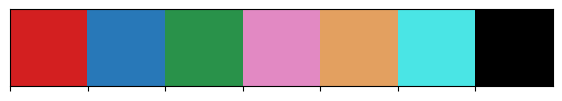

In [4]:
with open("results/for_plots/perturbations_palette.json", "r") as f:
    perturb_palette = json.load(f)
perturb_palette["None"] = [0., 0., 0., 1.]  # Black
sns.palplot(perturb_palette.values())

# Step 1: Fit dose response curves to obtain peptide $\mathrm{EC}_{50}$
Using a similar fitting function than the MSKCC fits, but with extra parameters for the background activation and the effective number of cells in a binomial model of error bars for the percentage of active cells. 

We performed both least-squares and MCMC parameter estimation. From the LSQ fits, we used the jacobian of the cost function at the best fit point to estimate a standard deviation on the EC50 (a diagonal element of the inverse jacobian is the parameter's variance). From MCMC samples, we directly obtain the actual parameter estimate's variance and confidence interval. 

For this HHAT library, there are 172 peptides (+4 controls), and for each, $32 \times 1000$ parameter samples: huge results file. So, we have just calculated summary statistics of the parameter distributions, mainly the standard deviation of the parameters' marginal posterior distributions. For model CI calculation, we will sample log-normal values of EC50 from this approximate distribution

We will use the maximum a posteriori (MAP) estimate of parameters when plotting the best antagonism model prediction line. 

In [5]:
# Fit results
df_ec50_stats = pd.read_hdf(os.path.join("results", "pep_libs", "hhatv4_ec50_mcmc_stats_backgnd.h5"), key="df")
df_ec50_stats = df_ec50_stats.sort_index(axis=1).drop(["mcmc_tau", "logprob"], axis=1)

# LSQ3 is worthless for HHAT, the background is too strong to use a model
# without a background. 
# Least-squares of the same full model as the MCMC simulations, to get meaningful
# Hessian estimates of parameter uncertainty
# Using CD25+ dose responses
param_names5 = ["V_inf", "n", "log_ec50_M", "logN_eff", "backgnd"]
stds_names5 = [a+"_std" for a in param_names5]
stds_renames = dict(zip(stds_names5, param_names5))
df_ec50_lsq5 = pd.read_hdf(os.path.join("results", "pep_libs", "hhatv4_ec50_lsq_results_backgnd_5.h5"), key="df")
df_ec50_lsq5 = pd.concat({"LSQ_5":df_ec50_lsq5[param_names5], 
                          "std_lsq":df_ec50_lsq5[stds_names5].rename(stds_renames, axis=1)}, 
                         names=["Feature", "Parameter"], axis=1)
df_ec50_stats = pd.concat([df_ec50_stats, df_ec50_lsq5], axis=1)
df_ec50_stats = df_ec50_stats.sort_index(axis=1).dropna()
df_ec50_stats

Feature                   LSQ_5                                           \
Parameter                 V_inf   backgnd  logN_eff log_ec50_M         n   
Antigen  TCR Peptide                                                       
HHAT-L8F 8   DMSO      0.850136  0.116546  4.431052  -3.679415  1.044007   
             F8A       0.849707  0.103799  4.510071  -2.949500  1.008485   
             F8C       0.850105  0.098491  4.445261  -3.796300  1.019123   
             F8D       0.850014  0.127122  4.360977  -3.032016  1.017811   
             F8E       0.850087  0.105425  4.328706  -3.526480  1.039235   
...                         ...       ...       ...        ...       ...   
             W6V       0.848938  0.104375  4.271555  -4.098764  0.940748   
             W6Y       0.847592  0.101534  4.432409  -2.559515  1.067094   
             WT        0.850127  0.118515  4.638930  -3.532503  1.048593   
             WildType  0.850145  0.107052  3.952456  -3.925407  1.024333   
             p8F       0.485880  0.258742  2.499717  -7.886283  1.028714   

Feature                     MAP                                           \
Parameter                 V_inf   backgnd  logN_eff log_ec50_M         n   
Antigen  TCR Peptide                                                       
HHAT-L8F 8   DMSO      0.835406  0.116125  5.136494  -3.818707  1.122786   
             F8A       0.801217  0.103897  5.081496  -2.965756  0.961817   
             F8C       0.822250  0.098938  4.937884  -3.704563  0.958493   
             F8D       0.868875  0.126462  5.263992  -3.341580  1.175923   
             F8E       0.863515  0.106562  5.140395  -3.286129  1.035786   
...                         ...       ...       ...        ...       ...   
             W6V       0.825376  0.103461  5.072436  -4.137654  0.951254   
             W6Y       0.836833  0.101315  5.067179  -2.739767  1.007493   
             WT        0.845248  0.119161  5.415792  -3.631511  1.118269   
             WildType  0.842037  0.108794  5.056761  -3.917142  0.958531   
             p8F       0.480476  0.261817  5.084953  -7.924491  1.170086   

Feature                 std_lsq                                           \
Parameter                 V_inf   backgnd  logN_eff log_ec50_M         n   
Antigen  TCR Peptide                                                       
HHAT-L8F 8   DMSO      0.400000  0.019190  1.985083   1.437113  0.991325   
             F8A       0.399642  0.018416  1.991701   2.747350  0.929983   
             F8C       0.399999  0.019225  1.988108   1.270202  0.979791   
             F8D       0.400000  0.019255  1.979656   3.442395  0.999459   
             F8E       0.400000  0.019227  1.978577   1.703780  0.995462   
...                         ...       ...       ...        ...       ...   
             W6V       0.399958  0.020271  1.974407   0.913286  0.872826   
             W6Y       0.399924  0.017414  1.986431   3.737736  0.979265   
             WT        0.400000  0.018967  1.997546   1.695218  0.995821   
             WildType  0.399996  0.019980  1.941644   1.109526  0.968679   
             p8F       0.046864  0.055073  1.421918   0.598723  0.837764   

Feature                   stdev                                           
Parameter                 V_inf   backgnd  logN_eff log_ec50_M         n  
Antigen  TCR Peptide                                                      
HHAT-L8F 8   DMSO      0.190590  0.018357  0.938752   1.277336  0.686639  
             F8A       0.191514  0.017801  0.912063   1.245968  0.696222  
             F8C       0.190172  0.018489  0.950043   1.317699  0.681065  
             F8D       0.190889  0.018434  0.935899   1.259718  0.685283  
             F8E       0.190319  0.017907  0.945476   1.287751  0.685687  
...                         ...       ...       ...        ...       ...  
             W6V       0.193102  0.020734  1.036075   1.361604  0.657120  
             W6Y       0.190150  0.017544  0.924664   1

In [6]:
# Compare the fits to raw data
response_name = "41BB+"
df_dose = load_raw_data_hhatv4(
    fname=os.path.join("data", "dose_response", "hhatlibrary4_cellData.h5"), 
    resp_name=response_name
)
tcr_to_ag_map = get_tcr_to_ag_map(df_dose)
print(tcr_to_ag_map)

{'8': 'HHAT-L8F'}


### Plot difference between MAP and LSQ (full, 5-parameter model)

In [7]:
def change_identity_for_wt(df):
    """ For a DataFrame of peptides, for each TCR, change a
    peptide which is unmutated for 'WT' and drop duplicates """
    df2 = df.copy()
    for ag, tcr, pep in df.index:
        if pep[0] == pep[2]:  # This is WT
            df2 = df2.rename({pep:"WT"}, level="Peptide", axis=0)
            
    df2 = df2.loc[~df2.index.duplicated(keep='first')].sort_index()
    return df2

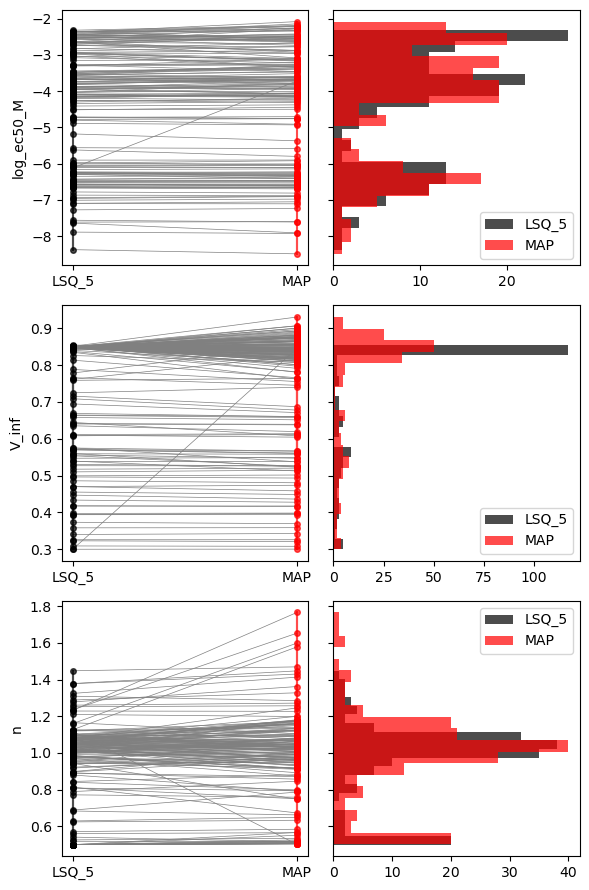

In [8]:
fig, axes = plt.subplots(3, 2, sharey="row")
fig.set_size_inches(6, 9)
xlabels = ["LSQ_5", "MAP"]
df_plot = df_ec50_stats.loc[:, xlabels].sort_index(axis=1)
for i, p in enumerate(["log_ec50_M", "V_inf", "n"]):
    yvals = df_plot.xs(p, level="Parameter", axis=1).dropna()
    axes[i, 0].plot(
        np.arange(2).reshape(2, 1), yvals[xlabels].values.T, 
        ls="-", color="grey", lw=0.5
    )
    npeps = yvals.shape[0]
    axes[i, 0].plot(np.zeros(npeps), yvals[xlabels[0]].values, marker="o", color="k", ms=4, alpha=0.7)
    axes[i, 0].plot(np.ones(npeps), yvals[xlabels[1]].values, marker="o", color="r", ms=4, alpha=0.7)
    axes[i, 0].set_xticks(np.arange(2))
    axes[i, 0].set_xticklabels(xlabels)
    axes[i, 0].set_ylabel(p)
    
    # Now histograms or KDEs
    hist_map, edges_map = np.histogram(yvals["MAP"].values, bins=20)
    hist_lsq5, edges_lsq5 = np.histogram(yvals["LSQ_5"].values, bins=20)
    axes[i, 1].barh(y=edges_lsq5[:-1], width=hist_lsq5, height=np.diff(edges_lsq5), 
                    align="edge", color="k", alpha=0.7, label="LSQ_5")
    axes[i, 1].barh(y=edges_map[:-1], width=hist_map, height=np.diff(edges_map), 
                    align="edge", color="r", alpha=0.7, label="MAP")
    axes[i, 1].legend()
fig.tight_layout()
plt.show()
plt.close()

In [9]:
# One example where their EC50 and mine are very different. 
# But this is a very weak peptide, response near zero, so 
# the EC50 should be large: mine is better. 
print("Max differences args:", 
      np.argmax(np.abs(df_plot["MAP"] - df_plot["LSQ_5"]).values, axis=0))
df_plot.iloc[130]

Max differences args: [130  29  16 130 130]


Feature  Parameter 
LSQ_5    V_inf         0.300000
         backgnd       0.134767
         logN_eff      3.605731
         log_ec50_M   -6.118220
         n             1.118095
MAP      V_inf         0.845080
         backgnd       0.143153
         logN_eff      4.596857
         log_ec50_M   -3.723117
         n             0.501775
Name: (HHAT-L8F, 8, V5R), dtype: float64

## Steps 1.2, 1.3: not necessary for our own HHAT library
Step 1.2: converting EC50s from $\mu$g/mL to M dose units: our dose responses are already in M, no need to convert. 

Step 1.3: inferring missing EC50s using the maximum response: thankfully, all peptides worked in our HHAT experiment (v4), so we do not have any missing EC50 to infer. 

## 1.4 Ensure non-responsive peptides are either null or antagonists
In the absence of a measurable dose response, it's impossible to tell whether a peptide will be an antagonist or a completely null peptide. 

So, for peptides with maximum response too small, or amplitude of response above background too small, or EC50 very close to the maximum, set their EC50 half-way between a completely null EC50 (ensuring $\tau \approx 0$) and their fitted EC50, and increase their standard deviation such that when sampling EC50s, they can be either antagonists or null. 

In [10]:
# non-responsive peptides: max response < 25 % (which is the max. background)
# and difference in response between min and max doses (in the curve fit) < DMSO
# Exploiting this DMSO control to set the threshold is a good idea. 
choice_method = "MAP"
choice_std = "std_lsq" if choice_method.startswith("LSQ") else "stdev"

max_ec50_found_M = df_ec50_stats[(choice_method, "log_ec50_M")].max()
p_best_fits = df_ec50_stats.loc[:, (choice_method, ["V_inf", "n", "log_ec50_M", "backgnd"])]
resp_difference = pd.Series(0.0, index=df_ec50_stats.index)
max_resp = pd.Series(0.0, index=df_ec50_stats.index)
# MSKCC threshold: max dose is 10^2 ug/mL = 10^-4 M approx.
# min dose is 10^-2 = 10^-8
# Use this same max. dose to evaluate the change in response. 
for k in resp_difference.index:
    max_resp.loc[k] = hill_with_back_diff(-4, p_best_fits.loc[k].values)
    resp_difference.loc[k] = max_resp.loc[k] - hill_with_back_diff(-8, p_best_fits.loc[k].values)

#resp_difference_thresh = resp_difference.at[("HHAT-L8F", "8", "DMSO")]
# Compute a list of non-responsive peptides based on the following criteria
resp_difference_thresh = 0.04  # consistent with MSKCC analysis
max_resp_thresh = 0.2
no_response_peps = ((resp_difference <= resp_difference_thresh) & (max_resp < max_resp_thresh))
print(no_response_peps)
print("Found {} null peptides".format(no_response_peps.sum()), 
      "with max. response < {} % and difference in response <= ".format(max_resp_thresh*100.0)
      +"{} % cells".format(resp_difference_thresh*100))
print("Setting their EC50 to a large value ensuring their tau < 0.1 s")
print("And setting the std of these EC50s to a correspondingly large value")

# Treat these peptides
do_treat_null = True
df_ec50_stats_treat = df_ec50_stats.copy()
if do_treat_null:
    max_null_ec50 = 3.0
    new_null_ec50 = 0.5 * (max_null_ec50 + df_ec50_stats.loc[no_response_peps, (choice_method, "log_ec50_M")])
    #new_null_ec50 = max_null_ec50
    df_ec50_stats_treat.loc[no_response_peps, (choice_method, "log_ec50_M")] = new_null_ec50

    # The original fit and the max EC50 are both two standard deviations away from the assigned value.  
    diff_to_fit = (max_null_ec50 - new_null_ec50) * 0.5
    df_ec50_stats_treat.loc[no_response_peps, ("stdev", "log_ec50_M")] = np.abs(diff_to_fit)

# Unfortunately, the WT peptide in the new batch ends up as a Null dose response
# based on the DMSO threshold. 
# (control WildType is OK)
df_ec50_stats_treat[choice_method]

Antigen   TCR  Peptide 
HHAT-L8F  8    DMSO        False
               F8A         False
               F8C         False
               F8D         False
               F8E         False
                           ...  
               W6V         False
               W6Y          True
               WT          False
               WildType    False
               p8F         False
Length: 176, dtype: bool
Found 36 null peptides with max. response < 20.0 % and difference in response <= 4.0 % cells
Setting their EC50 to a large value ensuring their tau < 0.1 s
And setting the std of these EC50s to a correspondingly large value


Parameter                 V_inf   backgnd  logN_eff  log_ec50_M         n
Antigen  TCR Peptide                                                     
HHAT-L8F 8   DMSO      0.835406  0.116125  5.136494   -3.818707  1.122786
             F8A       0.801217  0.103897  5.081496   -2.965756  0.961817
             F8C       0.822250  0.098938  4.937884   -3.704563  0.958493
             F8D       0.868875  0.126462  5.263992   -3.341580  1.175923
             F8E       0.863515  0.106562  5.140395   -3.286129  1.035786
...                         ...       ...       ...         ...       ...
             W6V       0.825376  0.103461  5.072436   -4.137654  0.951254
             W6Y       0.836833  0.101315  5.067179    0.130116  1.007493
             WT        0.845248  0.119161  5.415792   -3.631511  1.118269
             WildType  0.842037  0.108794  5.056761   -3.917142  0.958531
             p8F       0.480476  0.261817  5.084953   -7.924491  1.170086

[176 rows x 5 columns]

## Plot the final dose response fits
Including the missing, inferred EC50s. These fits will be worse, but just checking that there is nothing ludicrous coming out of them. 

In [11]:
def hill_norm(x, p3):
    a, n, k = p3
    return a / (1.0 + 10.0 ** (n * (k - x)))

In [12]:
def recover_base_pep_seq(mut_pep_set):
    # Remove "WT", "L8F" (mutation from the true WT), "p8F" 
    # not useful to reconstruct sequence
    for pep in ["WT", "L8F", "p8F"]:
        try:
            mut_pep_set.remove(pep)
        except:
            pass
    # From the list of all peptide mutants in form XiY, keep just the Xi
    # elements, which indicate amino acid X is at position i-1 in WT sequence
    pep_marks = np.unique(list(map(lambda x: x[:2], mut_pep_set)))
    base_pep_seq = [""] * len(pep_marks)
    for m in pep_marks:
        aa, pos = m[0], int(m[1]) - 1
        if base_pep_seq[pos] != "":
            raise ValueError("Conflicting amino acids in position"
                +"{}: {} and {}".format(pos, aa, base_pep_seq[pos])
            )
        else:
            base_pep_seq[pos] = aa
    return "".join(base_pep_seq)

In [13]:
# Plot the LSQ or MAP fits and the data
def full_plots_fits(df_data, df_fit, **kwargs):
    """ Plot all TCRs and peptides for one antigen """
    pep_name = kwargs.get("pep_name", "")
    dose_name = kwargs.get("dose_name", "Dose (ug/mL)")
    resp_name = kwargs.get("resp_name", "Response (% CD137+)")
    param_names = kwargs.get("param_names", ["V_inf", "n", "log_ec50_ugmL", "backgnd"])
    base_pep = kwargs.get("base_pep", "WT")
    
    # Prepare line styles
    amino_acids = np.unique(list("".join(df_data.index.get_level_values("Peptide").unique())))
    amino_acids = sorted([a for a in amino_acids if a.isalpha()])
    colors = sns.color_palette(n_colors=len(amino_acids))
    colors = {amino_acids[i]:colors[i] for i in range(len(amino_acids))}
    colors[base_pep] = (0.0,)*3  # black for WT
    lstyles = {amino_acids[i]:("-" if i < 10 else "--") for i in range(len(amino_acids))}
    lstyles[base_pep] = "-"
    markers = {amino_acids[i]:("o" if i < 10 else "^") for i in range(len(amino_acids))}
    markers[base_pep] = "s"
    
    if base_pep != "WT":
        colors["WT"] = "b"
        lstyles["WT"] = ":"
        markers["WT"] = "^"
    
    tcr_subset = df_data.index.get_level_values("TCR").unique().sort_values()
    x_doses = np.log10(df_data.columns.get_level_values(dose_name).astype(float).values)
    
    sub_col_map = {}
    all_mut_peps = list(df_fit.index.get_level_values("Peptide").unique())
    base_pep_seq = recover_base_pep_seq(all_mut_peps)
    n_rows = len(tcr_subset)
    n_cols = len(base_pep_seq)
    
    # Determine Hill model fitted
    if "backgnd" in df_fit.columns:
        dose_fct = hill_with_back_diff
    else:
        dose_fct = hill_norm
    fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
    axes = np.atleast_2d(axes)
    x_range = np.linspace(x_doses.min(), x_doses.max(), 101)  # log conc.
                
    for i, tcr in enumerate(tcr_subset):
        pep_set = df_fit.xs(tcr, level="TCR").index.get_level_values("Peptide").unique()
        axes[i, 0].set_ylabel("TCR {}".format(tcr) + "\n" + resp_name)
        for jj, pep in enumerate(pep_set):
            y_responses = df_data.loc[(tcr, pep), :].values
            params = df_fit.loc[(tcr, pep), param_names].values
            # Error bars from N_eff
            errors = np.sqrt(y_responses * (1.0 - y_responses) / 10.0**df_fit.at[(tcr, pep), "logN_eff"])
            if np.any(np.isnan(errors)):
                errors = 0.0
            # Special case: this is the base peptide sequence, draw in all columns
            if pep == base_pep or pep[0] == pep[-1]:
                for j in range(n_cols):
                    clr = colors[base_pep]
                    axes[i, j].errorbar(x_doses, y_responses, yerr=errors, 
                        marker="o", ls="none", mfc=clr, mec=clr, label=base_pep, ecolor=clr)
                    axes[i, j].plot(x_range, dose_fct(x_range, params), 
                        color=clr, ls="-", label=base_pep)
                    
            # Regular case: mutated amino acid
            elif pep == "WT":  # True WT peptide
                clr = colors[pep]
                ls = lstyles[pep]
                mark = markers[pep]
                j = int(base_pep[1]) - 1
                axes[i, j].errorbar(x_doses, y_responses, yerr=errors,
                    marker=mark, ls="none", mfc=clr, mec=clr, ecolor=clr)
                axes[i, j].plot(x_range, dose_fct(x_range, params), 
                    color=clr, ls=ls, label=pep)
            else:
                # Figure out in which plot to place this peptide based on the 
                # TCR and the amino acid substitution position
                # Infer the color and line style based on the substitute amino acid
                clr = colors[pep[2]]
                ls = lstyles[pep[2]]
                mark = markers[pep[2]]
                j = int(pep[1]) - 1
                axes[i, j].errorbar(x_doses, y_responses, yerr=errors,
                    marker=mark, ls="none", mfc=clr, mec=clr, ecolor=clr)
                axes[i, j].plot(x_range, dose_fct(x_range, params), 
                    color=clr, ls=ls, label=pep[2])
    # Final bits of plotting
    fig.set_size_inches(2.25 * n_cols, 2.0 * n_rows + 1.0)
    for j in range(n_cols):
        axes[0, j].set_title("Position {} (".format(j+1) + base_pep_seq[j] + ")")
        dose_lbl = (r"Dose ($\mu$g/mL)" if dose_name == "Dose (ug/mL)" 
                    else dose_name.replace("_", " "))
        axes[-1, j].set_xlabel(dose_lbl)
    axes[-1, 0].set_xticks(axes[-1, 0].get_xticks())
    log_ticks = axes[-1, 0].get_xticklabels()
    lbls = list(map(lambda x: r"$10^{" + str(x.get_text()) + "}$", log_ticks))
    axes[-1, 0].set_xticklabels(lbls)
    axes[-1, 0].set_xlim([x_doses.min()-0.1, x_range.max()+ 0.1])
    fig.suptitle("Peptide {}: {}".format(pep_name, base_pep_seq))
    fig.tight_layout()
    
    return fig, axes


def standalone_legend(*leg_args, **leg_kwargs):
    fig1, ax1 = plt.subplots()
    ax1.set_axis_off()
    leg1 = ax1.legend(*leg_args, **leg_kwargs)
    fig1.canvas.draw()
    # First dummy drawing to get the legend size in inches
    leg_width = leg1.get_window_extent().width / fig1.dpi
    leg_height = leg1.get_window_extent().height / fig1.dpi
    plt.close()

    # Now, actual figure which we set at the right size
    fig, ax = plt.subplots()
    fig.set_size_inches(leg_width*1.05, leg_height*1.05)
    ax.set_axis_off()
    leg = ax.legend(*leg_args, **leg_kwargs)
    fig.tight_layout()
    return fig, ax, leg

# Create a stand-alone legend for amino acid substitutions
def full_plots_legend_aa(df_data, **kwargs):
    # Prepare line styles
    amino_acids = np.unique(list("".join(df_data.index.get_level_values("Peptide").unique())))
    amino_acids = sorted([a for a in amino_acids if a.isalpha()])
    colors = sns.color_palette(n_colors=len(amino_acids))
    colors = {amino_acids[i]:colors[i] for i in range(len(amino_acids))}
    colors["WT"] = (0.0,)*3  # black for WT
    lstyles = {amino_acids[i]:("-" if i < 10 else "--") for i in range(len(amino_acids))}
    lstyles["WT"] = "-"
    markers = {amino_acids[i]:("o" if i < 10 else "^") for i in range(len(amino_acids))}
    markers["WT"] = "o"
    
    leg_handles = [mpl.lines.Line2D([0], [0], label="WT", ls="-", marker="s", color=colors["WT"])]
    for aa in amino_acids:
        leg_handles.append(mpl.lines.Line2D([0], [0], label=aa, 
            ls=lstyles[aa], marker=markers[aa], color=colors[aa]))
    return standalone_legend(handles=leg_handles, **kwargs)
    

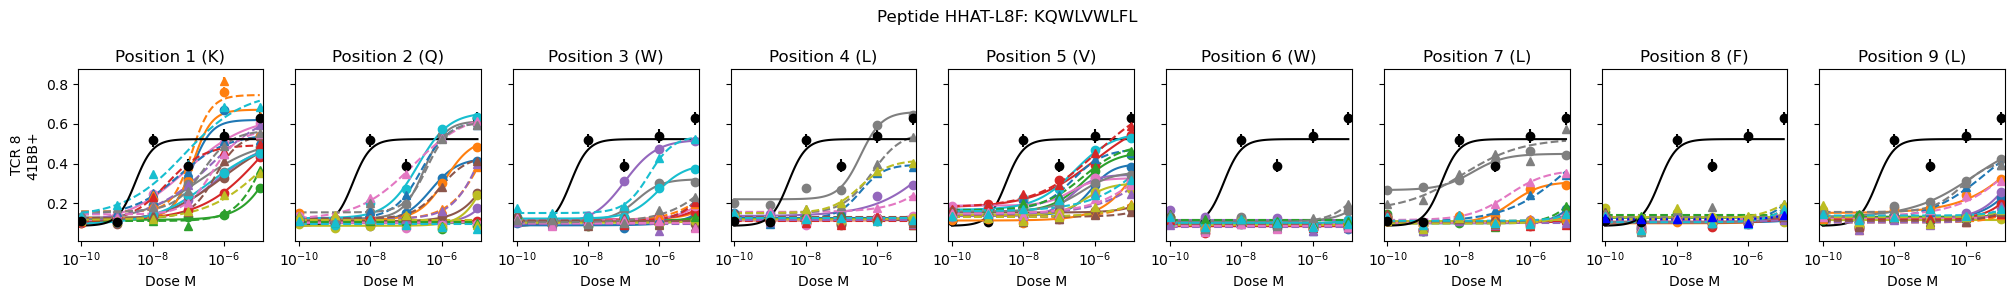

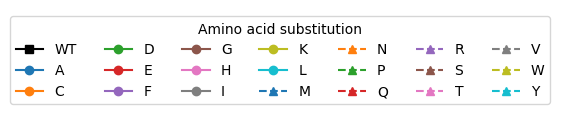

In [14]:
control_peps = ["WildType", "DMSO", "PMA/iono", "p8F"]
for ag in np.unique(list(tcr_to_ag_map.values())):
    figax = full_plots_fits(
        df_dose[response_name].xs(ag, level="Antigen").drop(control_peps, level="Peptide"), 
        df_ec50_stats_treat[choice_method].xs(ag, level="Antigen").drop(control_peps, level="Peptide"), 
        pep_name=ag, 
        dose_name="Dose_M", 
        param_names=["V_inf", "n", "log_ec50_M", "backgnd"], 
        base_pep="L8F", 
        resp_name=response_name
    )
    if do_save_plots:
        figax[0].savefig(os.path.join("figures", "dose_response", 
            "hhatv4_dose_response_MAP_fits_{}.pdf".format(ag)), transparent=True, bbox_inches="tight")
    plt.show()
    plt.close()
figaxes2 = full_plots_legend_aa(df_dose.xs(ag, level="Antigen").drop(control_peps, level="Peptide"), 
                                title="Amino acid substitution", ncols=7)
if do_save_plots:
    figaxes2[0].savefig(os.path.join("figures", "dose_response", 
            "hhatv4_dose_response_substitutions_legend.pdf"), transparent=True, bbox_inches="tight")
plt.show()
plt.close()

In [15]:
df_ec50_stats_treat.loc[("HHAT-L8F", "8", ["K1N", "Q2N"])]

Feature                  LSQ_5                                           \
Parameter                V_inf   backgnd  logN_eff log_ec50_M         n   
Antigen  TCR Peptide                                                      
HHAT-L8F 8   K1N      0.765875  0.142000  1.030560  -6.956707  1.159907   
             Q2N      0.842831  0.118341  4.656328  -4.723848  0.890087   

Feature                    MAP                                           \
Parameter                V_inf   backgnd  logN_eff log_ec50_M         n   
Antigen  TCR Peptide                                                      
HHAT-L8F 8   K1N      0.745121  0.158766  2.660409  -6.908398  1.598644   
             Q2N      0.848372  0.117511  5.112675  -4.705438  0.871366   

Feature                std_lsq                                           \
Parameter                V_inf   backgnd  logN_eff log_ec50_M         n   
Antigen  TCR Peptide                                                      
HHAT-L8F 8   K1N      0.143055  0.089484  0.983660   0.515619  0.882535   
             Q2N      0.397474  0.022107  1.998167   0.486246  0.421418   

Feature                  stdev                                           
Parameter                V_inf   backgnd  logN_eff log_ec50_M         n  
Antigen  TCR Peptide                                                     
HHAT-L8F 8   K1N      0.072710  0.049550  0.853229   0.307274  0.638969  
             Q2N      0.188968  0.022463  0.970619   0.431251  0.595093

## EC50 to $\tau$ conversion
### Reference point
They don't have N4 unfortunately. Let's assume CMV is something like N4. 

Now, a lot will depend on the choice of that reference: everything will be an antagonist if we choose that too low; nothing will be if we choose too high. So better associate CMV to something too high, so we certainly don't hyperinflate the number of antagonists we predict. 

No strong need to convert EC50s to tau immediately; to generate model CIs, we will generate a different EC50 for each sample, and these are the EC50s that we will convert to taus. 

In [16]:
# Choose reference point: based on comparing OT1 peptides to HHAT, 
# the previous CD25-based EC50 for HHAT-p8F was 6.200920534326603e-09 M
# and this corresponded to tau =  4.2049234098220065 s
ref_tau_p8f = 4.2049234098220065
# Go get the previous p8F EC50 as a reference, this was higher-resolution. 
df_cd25_ec50s = (pd.read_hdf("data/dose_response/experimental_peptide_ec50s_blasts.h5", 
                key="df").xs("CD25fit", level="Method"))
df_cd25_ec50s = df_cd25_ec50s.groupby(["TCR", "Peptide"]).apply(geo_mean_apply)
ref_ec50_p8f = df_cd25_ec50s.loc[("HHAT", "p8F")]

# Reference from this new dataset instead, to account for batch effect in this experiment
ref_ec50_p8f = 10.0**df_ec50_stats.at[("HHAT-L8F", "8", "p8F"),(choice_method, "log_ec50_M")]  # in M
print("Reference EC50:", ref_ec50_p8f, "M")
print("Reference tau:", ref_tau_p8f, "s")
def ec50_to_tau(ec50: np.float64, ec50_ref=ref_ec50_p8f, tau_ref=ref_tau_p8f):
    """ 
    Convert an absolute EC50 (in M) to a binding time, 
    with SIINFEKL = 10 s as a reference. 
    """
    return convert_ec50_tau_relative(ec50 / ec50_ref, tau_ref, npow=6)

Reference EC50: 1.1898954192945727e-08 M
Reference tau: 4.2049234098220065 s


In [17]:
mut_ags_taus = (10.0**df_ec50_stats.loc[:, (choice_method, "log_ec50_M")]).apply(ec50_to_tau)
mut_ags_taus

Antigen   TCR  Peptide 
HHAT-L8F  8    DMSO        0.869883
               F8A         0.627050
               F8C         0.832601
               F8D         0.724335
               F8E         0.709084
                             ...   
               W6V         0.983147
               W6Y         0.574960
               WT          0.809583
               WildType    0.903372
               p8F         4.204923
Name: (MAP, log_ec50_M), Length: 176, dtype: float64

# Step 2: obtain error bars on surface antigen densities (Her2 and HLA)
Quite easy since I do the same thing for the TCR/CAR predictions: reuse functions!

There is also uncertainty on the loading $K_D$. 

## 2.1 Pulse concentration to antigen number conversion
Assuming the peptides load correctly on tumor cells. 

In other words, loading EC50 of the peptide is the same as for OT1 peptides. Obviously, this is not always true.  

### Load model parameters at the same time as loading parameters

In [18]:
# Load model best fits
fit_conc = ["1uM", "1nM"]
analysis_res_fname = "mcmc_analysis_tcr_car_both_conc.json"
with open(os.path.join("results", "mcmc", analysis_res_fname), "r") as jfile:
    all_results_dicts = json.load(jfile)
    del jfile

# Go back to linear-scale parameters
chosen_kmf = (1, 2, 1)
pvec_best = np.asarray(all_results_dicts.get(str(chosen_kmf)).get("param_estimates").get("MAP best"))

In [19]:
# Load constant parameter values
samples_fname = samples_fname = "mcmc_results_tcr_car_both_conc.h5"
with h5py.File(os.path.join("results", "mcmc", samples_fname), "r") as rfile:
    data_group = rfile.get("data")
    # Load samples too, for CI generation
    mcmc_samples_car = rfile.get("samples").get(str(chosen_kmf))[()]
    fit_param_names = list(rfile.get("samples").attrs.get("param_names"))
    l_conc_mm_params = data_group.get("l_conc_mm_params")[()]
    cost_args_loaded = [data_group.get(a)[()]
                        for a in data_group.attrs.get("cost_args_names")]
    del data_group, rfile

In [20]:
# Multiply this by the number of MHC per tumor cell
def pulse_to_frac_loaded(conc, k_d=l_conc_mm_params[1]):
    """ Compute the fraction of MHC that will be loaded at a pulse conc (in uM)"""
    return michaelis_menten(conc, 1.0, k_d)

## 2.2 Load surface molecule numbers

We do not want to use the single-cell data because the model relies on an average APC and an average T cell. But there is still some uncertainty on the average antigen levels, so for parameters $L^T$, $L^C$, assume a log-normal distribution (Gaussian in log scale) centered on the mean and with variance equal to the variance on the mean estimator, as reported in the summary statistics. 

Then, when generating model CI, also include these ligand number distributions as sources of uncertainty: sample from them. 

In [21]:
# Load all CAR and TCR antigen numbers on the tumor lines used for each TCR line
molec_counts_filename = "data/surface_counts/surface_molecule_summary_stats.h5"
mtc = "Geometric mean"

# Surface area of cells, relative to E2aPBX
# Unsure about surface area of PC9 and BEAS2B, using 1.0
size_factors = {"E2APBX":1.0, "Nalm6":2.0, "PC9":1.0, "BEAS2B":1.0}

# Get MHC and tumor antigen levels, as well as receptor numbers and loading EC50. 
# For each, also get the geometric mean, and the standard deviation of the mean estimator
# TCR, CAR, CD19, MHC, and loading EC50 parameters
molec_loads = load_tcr_car_molec_numbers_ci(
    molec_counts_filename, mtc, tumor_type="PC9",
    tcell_type="OT1_CAR", tumor_antigen="Her2", 
    data_fold="data/"
)
# Means
cell_info_means = {
    #"tcr": molec_loads[0],  # This is the default used for TCR/CAR fits
    #"car": molec_loads[1],  # This is the default too
    "car_ag": molec_loads[2] / size_factors["PC9"],
    "l_conc_mm_params": [molec_loads[3][0] / size_factors['PC9'], molec_loads[3][1]]
}
# Standard deviations and #dofs for sampling from Student's t distribution
all_stds, all_ndofs = molec_loads[5], molec_loads[6]

print(cell_info_means)

{'car_ag': np.float64(33294.22517316961), 'l_conc_mm_params': [np.float64(737752.5155382438), np.float64(0.10834035000347023)]}


# Step 3: model predictions for all peptides with MCMC
## Implementation
Not much more complicated to account for uncertainty in $L^T$, $L^C$, and $\tau^T$: for each model parameter sample, also sample a ligand density (same for all peptides in that sample), and a $\tau^T$ for each peptide. Repeat many times to get good statistics on the FC predictions of each antigen, and ultimately on the fractions of antigen types. 

Still, we will need custom code that samples all these distributions for each replicate; can't reuse the `confidence_predictions_car_antagonism function`, because it doesn't sample peptide taus. But we can reuse the model panel functions: `apply antag_ratio_panel_tcr_car_numbers` to each sample, after adjusting the ligand densities in the arguments passed to it for each parameter sample. 

Most importantly, include uncertainty in the peptides EC50s. Need to use EC50 and pulse concentrations as Index levels in the DataFrame concatenating all the results, becase these will correspond to varying taus and ligand numbers, respectively, for each sample of the antigen numbers, loading EC50, and peptide EC50s. 

### Analysis function
We will want to count fractions of antagonists, agonists, null peptides, so we want to return model values from all individual MCMC samples here, not just aggregated statistics. So define a new analysis function that just concatenates the original samples and aggregate statistics in separate columns. 

In [22]:
def concatenate_samples_stats(df_samples, ser_best):
    # Compute usual statistics
    df_stats = compute_stats_ci(df_samples, ser_best)
    
    # Then, return all samples too
    df_samples_stats = pd.concat({"stats":df_stats, "samples":df_samples}, names=["Feature"], axis=1)
    return df_samples_stats

In [23]:
dens_name = "TCR_Antigen_Pulse_uM"

# Prepare the DataFrame with relevant log10(EC50) of peptides
df_logec50_info = pd.DataFrame(0.0, index=df_ec50_stats_treat.index, 
                    columns=pd.Index(["estimator", "std"], name="Quantity"))
df_logec50_info["estimator"] = df_ec50_stats_treat.loc[:, (choice_method, "log_ec50_M")].copy()
df_logec50_info["std"] = df_ec50_stats_treat.loc[:, (choice_std, "log_ec50_M")].copy()

# Prepare the pandas MultiIndex specifying conditions to predict
# Do not include TCR_Antigen_tau, since this will change
# at each CI sample; last level should be pulse concentration, 
# previous levels should specify the peptide to recover its
# logEC50s' mean and standard deviation. 
pulse_concs = [1e-3, 1e0]  # predict 1 uM and 1 nM
cond_index_mskcc = (pd.concat({k:df_logec50_info for k in pulse_concs}, names=[dens_name])
         .index.reorder_levels(["Antigen", "TCR", "Peptide", dens_name]).sort_values())

# For all peptides, predict antagonism
seedseq = np.random.SeedSequence(0xa85966d4fc40a221f8f9eacfc5a98cbd)

# Cell ligand numbers mean estimators, standard deviations, n_dofs
# were loaded above: cell_info_means, all_stds, all_ndofs
# Compute CI. Args: model_panel, psamples, pbest, grid_pt, cond_index, pep_log10ec50s
# kwargs: analysis_fct, other_args, seed, n_samp, tcr_pulse_lvl, cell_info, molec_stds, molec_dofs
df_antagonism_mut, pep_logec50_samples = confidence_predictions_car_antagonism_ligands(
    antag_ratio_panel_tcr_car, 
    mcmc_samples_car,
    pvec_best,
    chosen_kmf,
    cond_index_mskcc, 
    df_logec50_info,
    analysis_fct=concatenate_samples_stats,#compute_stats_ci, 
    other_args=cost_args_loaded,
    seed=seedseq,
    n_samp=n_boot, 
    tcr_pulse_lvl=dens_name,
    cell_info=cell_info_means, 
    molec_stds=all_stds,
    molec_dofs=all_ndofs, 
    ec50_tau_refs=(ref_ec50_p8f, ref_tau_p8f)
)

# Put back nice pulse concentration labels
df_antagonism_mut = df_antagonism_mut.rename(write_conc_uM, level=dens_name)
df_antagonism_mut = df_antagonism_mut.dropna()
df_antagonism_mut

Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)


Feature                                             stats                      \
                                           percentile_2.5    median      mean   
Antigen  TCR Peptide  TCR_Antigen_Pulse_uM                                      
HHAT-L8F 8   DMSO     1nM                        0.152209  0.200263  0.269530   
                      1uM                        0.131767  0.171982  0.219893   
             F8A      1nM                        0.156083  0.230927  0.336569   
                      1uM                        0.132874  0.170742  0.190760   
             F8C      1nM                        0.150913  0.199924  0.274192   
...                                                   ...       ...       ...   
             WT       1uM                        0.130298  0.172041  0.208732   
             WildType 1nM                        0.149126  0.196937  0.268696   
                      1uM                        0.130731  0.173017  0.232346   
             p8F      1nM                        0.710533  3.204670  3.670256   
                      1uM                        1.225545  6.204572  6.380941   

Feature                                                         \
                                            geo_mean      best   
Antigen  TCR Peptide  TCR_Antigen_Pulse_uM                       
HHAT-L8F 8   DMSO     1nM                   0.238432  0.192442   
                      1uM                   0.191083  0.145030   
             F8A      1nM                   0.287478  0.304224   
                      1uM                   0.180579  0.147280   
             F8C      1nM                   0.240042  0.201461   
...                                              ...       ...   
             WT       1uM                   0.184963  0.144174   
             WildType 1nM                   0.234579  0.185718   
                      1uM                   0.193723  0.145843   
             p8F      1nM                   3.006563  3.454493   
                      1uM                   5.410649  6.524957   

Feature                                                       samples  \
                                           percentile_97.5          0   
Antigen  TCR Peptide  TCR_Antigen_Pulse_uM                              
HHAT-L8F 8   DMSO     1nM                         0.733442   0.618014   
                      1uM                         0.723920   0.195674   
             F8A      1nM                         0.891482   0.862458   
                      1uM                         0.437885   0.305322   
             F8C      1nM                         0.846203   0.175456   
...                                                    ...        ...   
             WT       1uM                         0.493682   0.159001   
             WildType 1nM                         0.757965   0.514055   
                      1uM                         0.783258   0.783061   
             p8F      1nM                         9.057420   6.696616   
                      1uM                        12.864889  12.368578   

Feature                                                                    \
                                                   1          2         3   
Antigen  TCR Peptide  TCR_Antigen_Pulse_uM                                  
HHAT-L8F 8   DMSO     1nM                   0.186555   0.380641  0.428177   
                      1uM                   0.173045   0.168869  0.722509   
             F8A      1nM                   0.702642   0.193343  0.182585   
                      1uM                   0.216105   0.164689  0.192997   
             F8C      1nM                   0.180629   0.428241  0.182595   
...                                              ...        ...       ...   
             WT       1uM                   0.169584   0.180210  0.181627   
             WildType 1nM                   0.189486   0.181222  0.197245   
                      1uM                   0.171209   0.169620  0.181

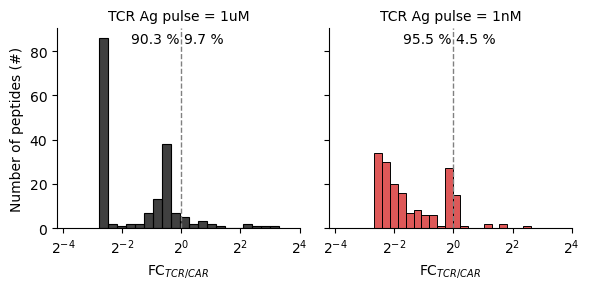

In [24]:
# Plotting the results
agdens_palette = {"1uM": perturb_palette["None"], "1nM": perturb_palette["AgDens"]}
nice_pulse_name = "TCR Ag pulse"
plotDf = np.log2(df_antagonism_mut["stats"])
new_lvl = "Antigen & mutation"
plotDf[new_lvl] = (plotDf.index.get_level_values("Antigen") 
                    + "-" + plotDf.index.get_level_values("Peptide"))
plotDf = plotDf.set_index(new_lvl, append=True)
plotDf = (plotDf.groupby([new_lvl, dens_name])  # Average across receptors
            .mean().sort_values("best")
         )
plotDf.index = plotDf.index.rename(names=nice_pulse_name, level=dens_name)
nice_fc_label = r"$\mathrm{FC}_{TCR/CAR}$"
plotDf = plotDf.rename(mapper={"best": nice_fc_label}, axis=1)

facet = sns.FacetGrid(
    data=plotDf.reset_index(), 
    hue=nice_pulse_name, 
    palette=agdens_palette, 
    hue_order=["1uM", "1nM"],
    col=nice_pulse_name, 
    col_order=["1uM", "1nM"],
)
facet.map(sns.histplot, nice_fc_label, bins=20)
#for ax in facet.axes.flat:
#    ax.axvline(0.0, ls="--", color="k", lw=1.0)
facet.figure.set_size_inches(facet.fig.get_size_inches()[0], facet.fig.get_size_inches()[1])
change_log_ticks(facet.axes.flat[0], which="x")
change_log_ticks(facet.axes.flat[1], which="x")

# Annotate with the fraction of antigens below FC = 1.0
pulse_concs = ["1uM", "1nM"]
for i in range(2):
    conc = pulse_concs[i]
    xlims =  facet.axes.flat[i].get_xlim()
    facet.axes.flat[i].set_xlim(xlims[0]-0.1, xlims[1])
    frac_below = (np.sum(df_antagonism_mut.xs(conc, level=dens_name)[("stats", "best")] < 1.0) 
                  / df_antagonism_mut.xs(conc, level=dens_name)[("stats", "best")].count())
    facet.axes.flat[i].axvline(0.0, ls="--", color="grey", lw=1.0)
    ymax = facet.axes.flat[i].get_ylim()[1]
    facet.axes.flat[i].annotate("{:.1f} %".format(100.0*frac_below), xy=(-0.075, ymax*.98), 
                                va="top", ha="right")
    facet.axes.flat[i].annotate("{:.1f} %".format(100.0*(1.0 - frac_below)), xy=(0.075, ymax*.98), 
                                va="top", ha="left")
facet.axes.flat[0].set_ylabel("Number of peptides (#)")

facet.figure.tight_layout()
if do_save_plots:
    facet.figure.savefig("figures/extra_predictions/hhatv4_antagonism_fc_distributions_pc9.pdf", 
                      transparent=True, bbox_inches="tight")
plt.show()
plt.close()

In [25]:
# Compute the fraction of agonists, antagonists, null peptides for each TCR and antigen
df_pc9_samples = np.log2(df_antagonism_mut["samples"].xs("1uM", level=dens_name))
null_thresh = 1.0  # log2 fold-change
totals_peps = df_pc9_samples.groupby(["Antigen", "TCR"]).count()
df_fracs_samples = pd.concat({
    "agonists": (df_pc9_samples >= null_thresh).groupby(["Antigen", "TCR"]).sum() / totals_peps, 
    "antagonists": (df_pc9_samples <= -null_thresh).groupby(["Antigen", "TCR"]).sum() / totals_peps, 
    "null": (np.abs(df_pc9_samples) < null_thresh).groupby(["Antigen", "TCR"]).sum() / totals_peps
}, names=["peptide_type"]).sort_index(level=["Antigen", "TCR"])
df_fracs_samples.columns = df_fracs_samples.columns.astype(np.int64)

df_antag_best = np.log2(df_antagonism_mut[("stats", "best")].xs("1uM", level=dens_name))
totals_peps_best = df_antag_best.groupby(["Antigen", "TCR"]).count()
df_fracs_best = pd.concat({
    "agonists": (df_antag_best >= null_thresh).groupby(["Antigen", "TCR"]).sum() / totals_peps_best, 
    "antagonists": (df_antag_best <= -null_thresh).groupby(["Antigen", "TCR"]).sum() / totals_peps_best, 
    "null": (np.abs(df_antag_best) < null_thresh).groupby(["Antigen", "TCR"]).sum() / totals_peps_best
}, names=["peptide_type"]).sort_index(level=["Antigen", "TCR"])

# Compute statistics of agonist, antagonist, null fractions across MCMC samples (columns)
df_fracs_samples_stats = pd.concat({
    "mean": df_fracs_samples.mean(axis=1), 
    "median": df_fracs_samples.median(axis=1),
    "percentile_2.5": df_fracs_samples.quantile(q=0.025, axis=1), 
    "percentile_97.5": df_fracs_samples.quantile(q=0.975, axis=1), 
    "best": df_fracs_best
}, names=["stats"], axis=1)
df_fracs_samples_display = (df_fracs_samples_stats.unstack("peptide_type")
                .reorder_levels(["peptide_type", "stats"], axis=1).sort_index(axis=1))
df_fracs_samples_display

peptide_type  agonists                                                  \
stats             best     mean  median percentile_2.5 percentile_97.5   
Antigen  TCR                                                             
HHAT-L8F 8    0.039773  0.06454  0.0625       0.034091        0.096591   

peptide_type antagonists                                                     \
stats               best      mean    median percentile_2.5 percentile_97.5   
Antigen  TCR                                                                  
HHAT-L8F 8      0.568182  0.681045  0.676136       0.590909        0.784091   

peptide_type      null                                                     
stats             best      mean    median percentile_2.5 percentile_97.5  
Antigen  TCR                                                               
HHAT-L8F 8    0.392045  0.254415  0.261364       0.164773        0.335227

In [26]:
# Plot fractions vs WT peptide EC50
def plot_fractions(df_fracs_stats, df_logec50s_estim, figax=None, colmap=None):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    if colmap is None:
        colmap = {"agonists": "xkcd:goldenrod", "antagonists": "purple", "null": "grey"}
    pep_idx = df_logec50s_estim.sort_values().index
    assert pep_idx.names == ["Antigen", "TCR"]
    x_vals = 1.0 / 10.0**df_logec50s_estim.loc[pep_idx]
    xlims = ax.get_xlim()
    for j, kind in enumerate(["agonists", "antagonists", "null"]):
        y_vals = df_fracs_stats.loc[pep_idx, (kind, "median")]
        y_lower = (y_vals - df_fracs_stats.loc[pep_idx, (kind, "percentile_2.5")]).clip(lower=0.0)
        y_upper = (df_fracs_stats.loc[pep_idx, (kind, "percentile_97.5")] - y_vals).clip(lower=0.0)
        if y_lower.size == 1:  # Error calling float on length 1 array
            y_err = np.asarray([[y_lower.iat[0]], [y_upper.iat[0]]])
        else:
            y_err = [y_lower, y_upper]
        ax.errorbar(x_vals, y_vals, yerr=y_err, color=colmap[kind], label=kind, 
                    lw=2.5, marker='o', elinewidth=2.5-0.5*j)
        #ax.plot(x_vals, y_vals, color=colmap[kind], label=kind)
    for pep in pep_idx:
        ax.annotate(pep, (x_vals.at[pep], y_vals.at[pep]), fontsize=8)
    if figax is None:
        ax.set(xlabel=r"p${}^{\mathrm{WT}}$ 1/EC50 ($\mathrm{M^{-1}}$)", ylabel="Fraction", xscale="log")
        ax.legend()
    else:
        ax.set_xlim(xlims)
    fig.tight_layout()
    return fig, ax
        

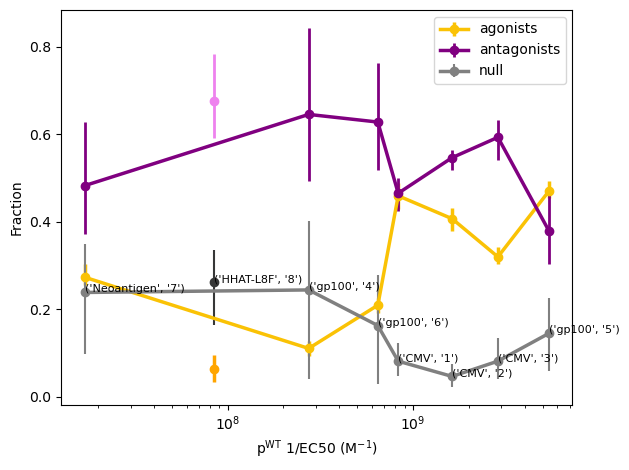

In [27]:
# Compare against MSKCC results
df_fracs_mskcc = pd.read_hdf("results/for_plots/mskcc_antagonism_fc_predictions_corrected_revised.h5", key="fracs_stats")
df_fracs_mskcc_display = (df_fracs_mskcc.unstack("peptide_type")
                .reorder_levels(["peptide_type", "stats"], axis=1).sort_index(axis=1))
df_ec50s_mskcc = pd.read_hdf("results/for_plots/mskcc_antagonism_fc_predictions_corrected_revised.h5", key="EC50_fits")
df_logec50_info_mskcc = pd.DataFrame(0.0, index=df_ec50s_mskcc.index, 
                    columns=pd.Index(["estimator", "std"], name="Quantity"))

choice_method_mskcc = "MAP"  #"LSQ_5"  #"MAP"
choice_std_mskcc = "std_lsq" if choice_method_mskcc.startswith("LSQ") else "stdev"  #"std_lsq"  # "stdev
df_logec50_info_mskcc["estimator"] = df_ec50s_mskcc.loc[:, (choice_method_mskcc, "log_ec50_M")]
df_logec50_info_mskcc["std"] = df_ec50s_mskcc.loc[:, (choice_std_mskcc, "log_ec50_M")]

fig, ax = plot_fractions(df_fracs_mskcc_display, df_logec50_info_mskcc.xs("WT", level="Peptide")["estimator"])

# Plot the HHAT point on top, use the reference EC50 for p8F
pred_colmap = {"agonists": "orange", "antagonists": "violet", "null": "xkcd:dark grey"}
df_dummy_ref_ec50_p8f = pd.Series(
    np.log10(np.asarray([ref_ec50_p8f])), 
    index=pd.MultiIndex.from_product([["HHAT-L8F"], ["8"]], names=["Antigen", "TCR"]), 
)
df_dummy_new_ec50_p8f = df_logec50_info.xs("p8F", level="Peptide")["estimator"]
fig, ax = plot_fractions(df_fracs_samples_display, df_dummy_new_ec50_p8f, 
                         figax=[fig, ax], colmap=pred_colmap)
if do_save_plots:
    fig.savefig(os.path.join("figures", "extra_predictions", 
        "universal_antagonism_pep_fractions_hhatv4_mskcc.pdf"), 
        transparent=True, bbox_inches="tight"
    )

plt.show()
plt.close()

# Also try without gp100, TCR 4 which has a lot of null (experimental issue?)
#figax = plot_fractions(df_fracs_samples_display.drop(("gp100", "4")), 
#        df_logec50_info.xs("WT", level="Peptide")["estimator"].drop(("gp100", "4")))
#figax[1].set_title("Without gp100, TCR 4")
#plt.show()
#plt.close()

In [28]:
# Save the predictions
if null_thresh > 0.25:
    res_file_name = "results/for_plots/hhatv4_antagonism_fc_predictions_corrected_revised.h5"
else:
    res_file_name = "results/for_plots/hhatv4_antagonism_fc_predictions_corrected_revised_nonull.h5"
if do_save_outputs:
    df_antagonism_mut["stats"].to_hdf(res_file_name, key="fc_stats")
    samples_df_to_save = df_antagonism_mut["samples"]
    samples_df_to_save.columns = samples_df_to_save.columns.astype(np.int64)
    samples_df_to_save.to_hdf(res_file_name, key="fc_samples")
    df_fracs_samples_stats.to_hdf(res_file_name, key="fracs_stats")
    df_fracs_samples.to_hdf(res_file_name, key="fracs_samples")
    df_ec50_stats_treat[["MAP", "stdev"]].to_hdf(res_file_name, key="EC50_fits")
    pep_logec50_samples.to_hdf(res_file_name, key="EC50_samples")
    print("Saved results")

Saved results
